# Setup

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pylab as plt
print("TensorFlow version: ", tf.__version__)

2023-06-19 11:08:18.726551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 11:08:19.060269: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-19 11:08:19.060333: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-19 11:08:20.558286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

TensorFlow version:  2.11.0


# Generate a TensorFlow Model
We'll build a CNN model to classify numbers from the MNIST dataset based on LeNet-5 Model with change that kernel size from 5x5 to 3x3.

In [2]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

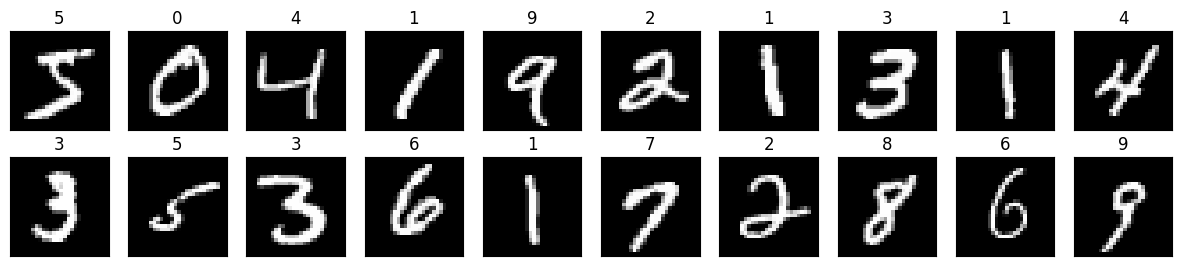

In [3]:
fig = plt.figure(figsize=(15,3))
for i in range(20):
    ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(train_images[i]), cmap='gray')
    ax.set_title(train_labels[i])

In [4]:
# Define the model architecture
# CNN
initializer = tf.keras.initializers.GlorotUniform(0)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer=initializer, bias_initializer=initializer),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer=initializer, bias_initializer=initializer),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer, bias_initializer=initializer),
    tf.keras.layers.Dense(10, kernel_initializer=initializer, bias_initializer=initializer)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
    train_images,
    train_labels,
    batch_size=128,
    epochs=20,
    validation_data=(test_images, test_labels)
)

2023-06-06 22:45:21.005647: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-06 22:45:21.005663: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-06 22:45:21.005678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (RaizelAsus): /proc/driver/nvidia/version does not exist
2023-06-06 22:45:21.005856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
469/469 [==============================] - 19s 40ms/step - loss: 0.2962 - accuracy: 0.9123 - val_loss: 0.0889 - val_accuracy: 0.9718
Epoch 2/20
469/469 [==============================] - 20s 42ms/step - loss: 0.0717 - accuracy: 0.9777 - val_loss: 0.0481 - val_accuracy: 0.9854
Epoch 3/20
469/469 [==============================] - 20s 43ms/step - loss: 0.0482 - accuracy: 0.9851 - val_loss: 0.0415 - val_accuracy: 0.9867
Epoch 4/20
469/469 [==============================] - 20s 43ms/step - loss: 0.0362 - accuracy: 0.9888 - val_loss: 0.0457 - val_accuracy: 0.9838
Epoch 5/20
469/469 [==============================] - 20s 43ms/step - loss: 0.0303 - accuracy: 0.9906 - val_loss: 0.0298 - val_accuracy: 0.9896
Epoch 6/20
469/469 [==============================] - 20s 43ms/step - loss: 0.0250 - accuracy: 0.9924 - val_loss: 0.0299 - val_accuracy: 0.9904
Epoch 7/20
469/469 [==============================] - 20s 43ms/step - loss: 0.0188 - accuracy: 0.9942 - val_loss: 0.0293 - val_accuracy:

In [4]:
model.summary()

NameError: name 'model' is not defined

In [5]:
# evaluate the model
# loss, accuracy = model.evaluate(valid_images, valid_labels, verbose=0)
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0) 
print(f'Accuracy: {accuracy*100}')

NameError: name 'model' is not defined

# Convert to a TensorFlow Lite model
Now you can convert the trained model to TensorFlow Lite format using the TensorFlow Lite Converter, and apply varying degrees of quantization. 

Beware that some versions of quantization leave some of the data in float format. So the following sections show each option with increasing amounts of quantization, until we get a model that's entirely int8 or uint8 data. (Notice we duplicate some code in each section so you can see all the quantization steps for each option.)

First, here's a converted model with no quantization:

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpjepb8p93/assets


INFO:tensorflow:Assets written to: /tmp/tmpjepb8p93/assets
2023-06-06 22:52:06.399727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 22:52:06.399768: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 22:52:06.400546: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjepb8p93
2023-06-06 22:52:06.402302: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 22:52:06.402321: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjepb8p93
2023-06-06 22:52:06.407971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-06-06 22:52:06.409376: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-06-06 22:52:06.457080: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [8]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


## Convert using integer-only quantization
To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [9]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_it = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp7c3cer0w/assets


INFO:tensorflow:Assets written to: /tmp/tmp7c3cer0w/assets
/home/thai/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 22:52:07.711926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 22:52:07.711956: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 22:52:07.712109: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7c3cer0w
2023-06-06 22:52:07.714057: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 22:52:07.714105: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7c3cer0w
2023-06-06 22:52:07.721312: I tensorflow/cc/saved_model/loader.cc:2

In [10]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_it)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


## Save the models as files
You'll need a **.tflite** file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [4]:
tflite_models_dir = pathlib.Path("./cnn_mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"cnn_mnist_model.tflite"

# Save the integer-only quantized model:
tflite_model_quant_it_file = tflite_models_dir/"cnn_mnist_quantization.tflite"

In [10]:
# Save the unquantized/float model:
tflite_model_file.write_bytes(tflite_model)

# Save the integer-only quantized model:
tflite_model_quant_it_file.write_bytes(tflite_model_quant_it)

NameError: name 'tflite_model' is not defined

# Run the TensorFlow Lite models
Now we'll run inferences using the TensorFlow Lite Interpreter to compare the model accuracies. 

First, we need a function that runs inference with a given model and images, and then returns the predictions:

In [16]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print(output)

    predictions[i] = output.argmax()

  return predictions

### Test the models on one image
Now we'll compare the performance of the float model and quantized model.

Let's create another function to print our predictions:

In [32]:
# Change this to test a different image
test_image_index = 0

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
    plt.grid(False)

Now test the float model:

In [33]:
# test_model(tflite_model_file, test_image_index, model_type="Float")

And test the integer-only quantized model

[ 92 112 108 120 131  89  38 195  90 129]


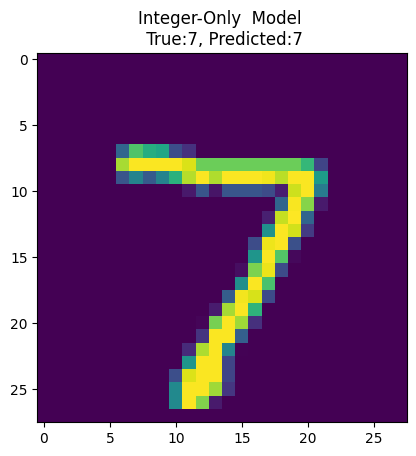

In [34]:
test_model(tflite_model_quant_it_file, test_image_index, model_type="Integer-Only ")

### Evaluate the models on all images
Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [20]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels == predictions) * 100) / len(test_images)
#   for idx in range(len(test_labels)):
#         if (predictions[idx] != test_labels[idx]):
#             print('Hihi')

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate the float model:

In [21]:
evaluate_model(tflite_model_file, model_type="Float")

[-11.495003    -5.312509    -6.638207    -2.6188102    0.39593327
 -12.219929   -28.08955     20.38971    -11.852329    -0.10137659]
[ -7.0610437   -0.19456883  27.688374   -11.393297    -9.080989
 -28.590506    -3.695948    -9.00463      0.6149545  -11.243023  ]
[ -9.085073    14.096173    -6.721463   -22.25647      0.40613747
 -11.182184    -9.187799    -0.77033037  -4.159207    -8.654012  ]
[ 17.905836  -16.314219  -11.452246  -15.990776   -8.201875   -7.460698
   2.3081398  -4.3186455  -7.318093   -3.7064228]
[-13.025734   -7.200462   -4.793999   -9.012546   18.20128    -8.091743
 -10.017955   -5.8368735  -6.676168   -1.406414 ]
[-10.190362   16.145489   -6.4188466 -23.737316   -1.0174762 -16.981544
 -12.077579    1.2798173  -5.3375244  -9.398396 ]
[-24.512693   -9.87448    -6.190189  -13.522917   17.24101    -6.3992605
 -18.574556   -6.3807845   6.263222    4.0975895]
[-19.950762    -9.656329    -3.8351977   -2.5204148   -1.3129879
  -8.622729   -30.471203    -7.2603745    0.14868

[-11.978941    -5.255983    -7.9269953    0.23628819  -4.488817
  -3.3359568  -13.394248    -0.22500527  22.506334   -10.785097  ]
[-13.228779     0.27931434  -6.1990523  -13.577793    18.082407
  -4.0180497   -7.152878    -6.3754964  -12.174415    -5.750765  ]
[-8.3760509e+00  1.3912223e+01 -7.5500307e+00 -2.1655003e+01
 -2.7464181e-03 -1.0031306e+01 -1.1022726e+01 -3.5834010e+00
 -3.2075233e+00 -8.3940029e+00]
[-11.110691    1.1247723   1.0064952  -0.5726224  -5.324357  -14.09171
 -28.793465   17.022234  -12.193345   -2.8232095]
[-20.093184  -10.021115   -2.2664104  23.315723  -13.887081   -1.5517162
 -16.38346   -14.333572    4.4108653   1.8124591]
[-21.488407   -4.605338  -11.57062    19.743065  -12.113614   -0.6836624
 -20.278782   -8.332833    0.7759379   6.1967583]
[-14.935536  -13.9570675  -7.1518126  -5.2959027 -16.970816   11.871777
  -2.5203807  -3.2523744  23.563482   -8.455575 ]
[-11.676083  -16.869421  -11.321902    0.5365859  -7.056763   -4.1117682
 -24.405344    4.36313

[-30.305798    -8.420543   -20.295095    34.06406    -12.740327
   3.6953976  -24.606441    -0.76518285   8.049022    -1.8847342 ]
[ -7.990548   -10.385979     0.12132996  -3.0821805   -6.4738274
 -14.765868   -32.386364    19.879261   -13.265737    -0.21113926]
[  1.4756258 -16.742239  -15.744255   -4.4438343  -7.4370747   6.197927
  19.598763  -23.507242    4.1502986   0.3384177]
[ 22.69452   -16.72347    -9.123312  -20.68811    -9.7842455  -1.9918861
  -6.806981    5.8358536 -11.816987   -7.449177 ]
[ 23.39491    -8.865594   -6.009862  -26.165245   -2.6346445 -12.5487385
   1.9976711 -11.598552  -10.116144   -3.270317 ]
[-33.35724   -15.027936  -11.168973   28.742022  -13.034255    4.59615
 -23.845486   -1.7291279  -5.5585327   4.8202295]
[ 13.042175    -4.2734675    0.07900685  -8.604083   -11.727446
  -5.724373    -4.8875914   -2.7896574    1.0160019   -6.531495  ]
[-12.458992   -9.970203   21.17737     8.902357  -16.567158  -20.00738
 -28.505648    6.166916    7.9342217  -9.17469

[-12.227144   -7.6101446  -6.806082   26.18037   -15.228032  -15.048393
 -17.202518    1.3434119   1.0533323  -6.0747466]
[-10.861797  -16.137224   -7.2751274  -2.8055573   4.5131617 -11.253634
 -26.358925    6.043159   -7.1916428  17.580181 ]
[-11.275258   -1.7389657   3.9200072   2.032741  -13.627171  -17.662462
 -31.06625    15.738141   -2.510013   -4.781272 ]
[ -8.108231    -2.5759594   -2.571182   -22.598015    -2.3627
  -0.03757599  34.09794    -30.96508    -11.078152   -22.000214  ]
[-28.581846 -27.767265 -12.185392  -6.275421   8.907676 -12.494301
 -46.54786    9.873151 -12.200029  24.917301]
[ -9.507336    13.2164545   -5.507319   -13.090939    -0.68962455
  -9.741241    -7.994581    -4.307897    -6.820402    -8.854893  ]
[-19.000267    -7.07229    -11.394468    19.188354   -10.230193
   5.353312   -10.735513   -14.7760935   -0.50465393   7.2726355 ]
[-27.501543    1.3789947   6.2005396   8.420961   -5.305348  -14.991867
 -34.31713    15.2162285  -9.99429     1.1964272]
[ -7.8

[-21.714804  -25.52469   -16.59435    -1.7175027   4.647023   -6.594883
 -37.283752    9.008424  -11.537285   27.080004 ]
[ -5.256485   12.9247875  -5.591958  -19.012083    3.3645027 -12.70196
 -12.378384   -1.0048807  -4.4976554  -8.525696 ]
[-12.651579   -0.7423554  -7.771084  -15.186352   21.871649  -11.861624
 -14.8698845  -5.6250815  -3.2420275  -3.1802065]
[-15.809304  -10.081334   -1.3578222  -5.8713307  -1.0093496  -8.517624
 -30.525476   16.351997   -5.3865147   3.4035497]
[-15.549229  -10.845771   -6.631589  -12.969986   25.985502   -9.55043
 -16.678268   -1.1633229  -7.4294186  -5.8516893]
[ -9.878616   -3.1604912  -0.977825    2.1695578 -14.321787  -22.052143
 -36.15741    19.457506    0.3761525  -3.6557367]
[-37.881542   -4.7278113 -23.814554   37.519238  -18.636671   10.0844345
 -26.77727    -7.295042    0.6570636   5.739668 ]
[-21.863997   -21.666449    -7.746587    -6.3513365    2.0299845
  -3.3729613  -29.163548    -0.66865283  -0.94137144  22.440401  ]
[-11.032957   -

[-23.701254  -17.505802  -13.636055   32.019577  -19.551008   -1.424298
 -28.636482    3.8994548   4.8176727   3.7302265]
[-15.53335    -13.4914255   -0.16774791  16.064396   -16.774668
  -3.5233257  -23.346241     7.083798    -6.232567    -2.9169073 ]
[ -7.002151   14.406224   -2.653533  -17.36238    -6.1450925 -15.951349
 -11.083348   -2.992067   -1.8480284 -15.10946  ]
[-11.384975  -18.748407   -2.1074607  -7.4031844   5.612518  -13.251475
 -28.024864    0.4832465  -5.600518   21.23295  ]
[-12.433435  -19.596712  -13.455881   -9.474075   -3.1364856  30.494553
   5.934609  -12.622619    6.5114107  -6.0193396]
[ -3.6593418  -3.2365363  33.08035    -8.515047   -4.9253583 -23.214289
 -24.042517   11.101613   -4.3790383 -13.902052 ]
[ -7.164152     0.04160099   4.6962805   -2.0406442   -7.689335
 -17.146559   -29.380127    15.864341    -6.9468703   -3.0137243 ]
[-32.824734  -10.663829  -11.251463   33.393505  -12.324277    4.9999886
 -29.568521   -5.3900466   2.4532907   5.442665 ]
[ -8.

[ -9.542555  -21.069191   -5.360856   -0.8748286   1.9852762 -12.084188
 -29.52317     2.6731148  -4.1625443  20.318424 ]
[-15.2525015  -10.497222    -8.628444    16.532455   -11.726923
  -3.5067494  -22.47056     -2.7816813    0.50100756   4.54335   ]
[-19.72235   -20.428253  -12.230651   -2.0085616   6.816973   -6.2090554
 -30.230751    1.1772959  -0.6602552  19.461172 ]
[ -1.5697737  -17.802795    -7.371524     0.38131607  -4.6374235
  -5.8096266    1.8733786   -8.60644     17.528337     1.2510883 ]
[-15.30567   -12.888244   -7.969514  -11.737634   25.223055   -5.3683033
 -27.140331    2.0523107  -3.3297565  -4.650559 ]
[-18.595102    4.013302    3.457743  -19.829292   28.6593     -4.3282156
  -2.6888478 -10.473087  -13.397422  -20.274435 ]
[-31.6891     -3.4984088 -12.525351   23.263288  -10.974177    6.4471126
  -9.323458   -7.422279    2.209551   -5.97493  ]
[ -9.290285   16.574781   -6.702173  -22.227577   -5.6399145 -14.278378
 -12.000528   -1.3011501  -2.3600993 -11.014136 ]
[

[-15.637663    1.0060984   2.0739937   2.6354299  -6.267794  -18.650553
 -23.817827   10.973504   -4.783106    3.1147647]
[ -7.5447416  -17.770098    -2.6008368    0.10354066  -2.281344
 -15.483535   -20.967747     0.14479083  -0.6756604   18.67026   ]
[-10.498715  -10.982642  -17.03742    -2.696731   -7.586648   11.281689
   5.444338  -16.454042   24.966492   -2.6359572]
[-18.910738   -6.630239   -4.9932804  16.371279   -9.298657    2.8887658
 -19.420198   -6.6950665  -4.1895037   6.314089 ]
[ 16.857458  -10.349953   -2.8328578 -14.474383  -16.590658   -1.7487748
  -9.27178     3.6405017 -10.341159   -6.81272  ]
[ -9.225564    -0.79485244   4.6940165    1.5754527  -13.829796
 -19.441097   -30.251896    13.407573    -1.6026423   -2.9186318 ]
[ -7.2884364   2.5322902  32.290985   -4.8780885  -6.8603396 -29.658268
 -19.110323    7.1014256  -0.677891  -14.5948515]
[-11.708238     3.235202     2.6630661   -0.16300446  -9.076704
 -19.46034    -32.96435     18.26519     -7.857915    -1.32006

[-11.125999   -2.8598258  -9.768823  -10.499898   -2.092946    3.076532
  12.137622  -14.871106    7.6250086  -5.152686 ]
[ 27.924887  -14.094792   -5.5852947 -23.024475   -9.530482  -14.386043
  -4.543955   -9.3701105 -20.214579    5.4872637]
[-24.178942    -3.1691186  -20.685904    30.883062   -18.268538
  -0.05753735 -32.82405      7.589427     0.0702934   -3.4559069 ]
[ -8.717799   13.735631   -6.4553785 -12.780106   -2.649356  -10.063242
  -8.348015   -2.162707   -6.4588113  -8.982852 ]
[ -2.6601496  12.8801565  -3.228641  -20.450397   -6.0738077 -18.213825
 -13.424937   -2.763932   -0.9338629  -8.880512 ]
[-16.194258    -3.3319376  -12.612125    14.0769      -6.5795727
  -4.178664   -13.338252     0.40669447  -0.14231315   4.0265436 ]
[-39.80224    -4.9952016  -9.5502405  39.308323  -19.332302   -3.8400161
 -27.271011    0.8659733   8.368735   -2.94483  ]
[-12.773852  -16.01667    -5.036252    6.535121   -3.2551024   3.2702413
 -23.350502   -6.7076     -0.6948557  15.004531 ]
[  

[  4.774203  -16.020376  -19.096481  -12.327088  -13.170148    6.7837467
  25.674957  -18.48265     3.5988166 -17.327116 ]
[-26.470497   -9.875933  -10.69549    -8.634525   23.337358   -8.832295
 -20.310987   -3.9880912  -8.400193    3.4638362]
[ -9.273012   -15.785668    -4.6764793   -0.50290644  -1.4560168
  -8.42239    -18.400522     1.5249274   -2.0061145   16.612831  ]
[-11.785843   -10.111301    -3.4275584  -17.265112    23.64978
  -0.22361854 -16.891176    -8.718812    -7.8667345   -9.070799  ]
[ -3.0048673  -8.317137  -13.792822  -19.343945    1.6700926  -3.7190292
  12.184833  -16.566364    2.7418647   6.4504843]
[ -5.8438945  -21.974665    -6.631952     0.13031673 -10.036676
  12.899921    14.568501   -21.455406    10.288903    -1.4403306 ]
[-30.297022   -7.200212   -8.144217   33.222607  -18.23689    -8.2439165
 -22.766685   -0.1631622   9.33809    -3.178985 ]
[  5.5440974  -9.184986   20.568903  -18.283707    0.6142205  -8.929457
 -14.369906    3.1154745  -5.197178   -9.017

[-13.727083     8.804436    22.517092    -7.7972403   -0.04015185
 -21.58158    -25.57056      6.411427    -0.07780054  -7.617448  ]
[ -2.1585562 -13.963708  -10.34321   -13.729518    3.1702547   2.0221934
  20.568035  -23.360382    3.2806184  -1.3138499]
[ -6.9580045   6.386205   22.599253  -14.856611    4.0971317 -26.948668
   1.5349977 -13.765285   -9.637971  -25.653069 ]
[-28.174486   -9.303313   -6.453195  -11.939926   27.70464    -7.047944
 -33.64841    -2.5628293 -10.053687   -1.0788132]
[-20.815262   -5.5457306  -8.980059  -19.205778   22.286177  -13.333624
 -19.275139    1.8402181   3.8292415  -4.7529497]
[ -7.8524528 -14.377923   -3.8777378   3.020679  -12.036461   -2.8165689
 -11.709674   -5.624658   23.135458   -4.7096343]
[ 14.729929   -10.872822    -8.466802   -10.14341    -15.637864
   0.247008    -3.0136037   -0.50280553   1.593869    -5.1917295 ]
[-13.167415   -7.563437   -9.25456   -18.596077   18.65476   -13.772072
  -5.397914    2.0868723  -6.2238173  -0.4871648]
[-

[-19.798302  -22.229597  -13.930014    2.6702385   3.1469297  -5.0005484
 -34.367973    2.9094498  -5.6399765  24.44074  ]
[-15.167345  -24.805159   -4.517172   -4.432798    4.93028    -9.4002905
 -34.893234    2.0561602  -1.0606908  23.008003 ]
[-10.998973     1.0060552   28.30781      0.93235123  -8.088218
 -26.444185   -20.973293     3.6155152   -3.4613948  -10.421282  ]
[-37.57351    -1.8651748  20.906158    7.7084403 -10.027019  -13.894939
 -22.959007    2.5996027  -3.5271897  -6.6405883]
[-15.801407   -22.841095   -18.235952    -6.4011784    1.5692594
   0.03541893 -22.694025    -4.481484     5.607624    23.186249  ]
[-24.090357  -11.851136   -6.6943645 -11.360667   24.934942   -7.358723
 -21.419079   -5.793731  -10.244092    4.356707 ]
[-21.041136   -5.962013   -4.8943577 -13.509459   29.260191   -5.9820943
 -20.931372   -6.380687  -10.109369   -4.240467 ]
[ -6.8413043   -3.7294438   27.938066     1.4980747  -16.019089
 -27.073275   -20.212755     4.8796067   -0.32155088 -13.548

[-11.796419   14.084385  -10.06123   -20.449394   -0.7021153  -8.321575
  -3.5860705  -4.273245   -3.7092295 -10.524866 ]
[  0.6228478  -20.497795    -9.950783     0.84898007  -8.267654
  -2.355456   -11.703149    -5.5784645   11.561269     1.0747687 ]
[ -2.601558   -6.6946087 -11.202822  -16.727638   -0.2302332   1.7177725
  29.66764   -22.584738   -6.396549  -22.608046 ]
[ -7.206522   -6.104509  -11.01202    -9.994636    3.4996305  -9.560514
 -20.227463   -2.0478697   0.8680631   9.901254 ]
[ 23.327105   -9.91184    -8.88014   -30.419777    1.1054196 -18.09386
   5.8077235 -12.638953  -10.013111    4.610202 ]
[  4.595353  -10.377778  -14.905557  -13.586322    2.0266757   1.4700344
  22.743332  -24.597198   -4.3007336 -14.832042 ]
[ 21.039669   -16.65813     -7.237006   -18.082705   -18.593536
   0.23379019  -2.043463     0.34560603  -9.01851     -6.067989  ]
[ 20.088945   -7.832825    2.55106   -19.992754  -12.975487  -14.2982025
  -9.1347     -1.7881536  -4.775384   -1.657122 ]
[ 25

[-17.112768   -17.692987   -10.652218    -0.98473454   4.047589
  -6.81251    -29.437597     3.578375    -6.374065    19.986126  ]
[-11.119187  -29.00601   -11.957487  -11.527057   -1.3622012  30.159023
  -9.751627  -25.725693    3.0449665  10.222322 ]
[-24.020704   -25.739737   -11.757277    -0.14432895   2.2454214
  -6.920572   -37.193924     3.3909223    2.4899428   26.890192  ]
[-12.481353   -0.6531388  -1.6516593   3.6911292  -6.066416  -17.598421
 -36.2134     19.17407    -7.892812    1.7699343]
[-32.40327    -10.394813   -12.776149    30.173485   -15.436189
   2.5988488  -22.902798     3.3330383    2.665408    -0.15788466]
[-11.254263  -25.354267  -24.709469  -14.774401  -12.678695   -5.204414
 -31.383276   35.375668  -17.49198     2.5639873]
[-12.746145    -7.9445024   -6.780928    -6.8967533    3.9688978
  -5.998864   -16.06151     -4.157122    17.12878      0.71380204]
[ 22.502129  -17.798738   -9.360523  -18.881828  -13.117804   -3.0127518
  -3.645054  -15.947202   -2.105787

[-11.494033  -14.968489   -9.501881   -5.0346365  -6.686177  -14.352254
 -28.777092   17.383862   -4.936386    2.393035 ]
[-16.72899      2.5403879   -5.549424    -0.9163127   -0.49747807
 -16.638865   -30.969975    21.176237    -8.480006    -0.7905236 ]
[ 20.62943    -14.188075    -5.1378856  -20.793102   -16.703064
  -6.462659    -4.7238107   -1.4834211   -8.182754    -0.71524984]
[-19.986181  -21.214823  -19.36249    -1.6496452  -3.4454312  24.772467
 -13.977975   -6.7115235   6.7097216   4.859184 ]
[-29.634027  -12.7298975 -19.157524    7.427161   -7.2070622  24.366468
 -16.711914   -4.0695276   2.5233898   8.5967455]
[ -9.489019  -17.041899   -6.904605    0.324921   -9.979061    2.166756
 -10.668061   -1.3780203  23.650644    0.6619614]
[ -9.888805    12.08244     -5.553921   -18.39486     -3.28513
 -10.996071   -12.276406    -0.73291904  -4.1267743   -8.547437  ]
[ 27.769087  -14.466989   -6.963017  -19.880037  -28.11899    -1.6138873
  -1.4497879  -1.1972458   1.1744914  -9.8715

[-11.051734   -8.876112   -0.4002574  -5.5565634  -4.9988804 -12.766872
 -29.612822   19.574474  -11.833631    3.087325 ]
[-18.934404  -15.691434  -12.974247    3.619063   -9.25268    31.651993
 -15.983111  -23.254745   -1.8459282   5.4723167]
[-31.33662    -9.420127  -24.234411    9.262367  -10.21955    25.326328
 -16.06792    -4.3822794   4.9227934   2.4651322]
[-13.301651   -20.479443    -8.766207    -0.23731673   4.6551547
  -5.946625   -29.79398      0.812421     0.7044867   16.730003  ]
[ -4.7981186   17.839428    -1.9754393  -22.003147     1.4035215
 -17.685396    -8.5756855    0.34900957  -1.115496   -12.4842415 ]
[-16.366003   -7.132419   -1.9952168  -6.1127806   1.6811097 -17.045721
 -36.08004    24.908955   -6.665295    0.8316799]
[-19.382404  -27.16403   -22.816063   -0.9268426  -7.854018   32.23847
 -15.509903  -14.908983    6.4785585   5.341583 ]
[-20.556854  -12.552156   -5.5557766 -12.245642   27.016699  -13.335814
 -17.3616    -10.142187   -7.2234364   1.4615991]
[-18.

[-15.077012  -12.480241   -7.642009    4.824146  -12.1244335   2.4927475
  -4.7346683  -5.1735506  25.09673    -5.6377115]
[ -8.598921  -15.989226   -7.9474697  -2.5183506  -1.596633  -13.2819195
 -22.707947    6.310433   -4.0144596  16.996351 ]
[-20.654543  -20.827381  -12.007385   -0.6492897   3.469212  -12.162293
 -34.51042     3.6421056  -1.714565   23.120167 ]
[-13.822235  -19.49384   -25.275146    6.6120677 -10.227884   25.756504
  -9.281522  -13.492243   11.739572   -3.6549358]
[-18.848597   -18.795763    -9.534545    -6.826778     3.317271
  -3.6723225  -30.954443     0.98161644  -0.6415765   22.867102  ]
[-18.643822  -15.654377   -4.5934725  -5.5828276  -7.6265006  -4.0639267
 -17.860973  -13.12321    30.300282    1.8617977]
[-10.099569   -6.2877603 -19.24098     1.7236503 -11.233718   10.210043
  -1.9867876  -2.0151775   1.2522335   0.8578711]
[ -9.2400055  11.267846   -4.715792  -14.295977   -5.078726  -10.455447
 -11.592723    1.4412608  -2.0887675  -5.8391137]
[ 15.290651 

[-38.96391   -11.641649  -17.867292   35.368023  -13.718153    6.6433787
 -29.792006    1.1534104   3.3310742  -1.8600658]
[-11.078749    -5.966398    -2.9808264   -3.7919312   -3.457046
  -4.6067877   -0.51525664 -13.404327    18.871313    -8.61553   ]
[ 20.00192    -6.9711046  -1.6881702 -17.638008  -16.59645    -7.6781073
  -3.7271416  -5.1328044  -2.7970533  -7.5646887]
[ -4.417654   -5.70885    32.84681     2.921566  -21.649096  -35.41886
 -27.759794    3.4674888  14.195079  -14.195282 ]
[-10.559844   11.3183775  -7.5679317 -21.928638   -2.10081    -8.537808
  -6.532207   -3.4693997  -1.5687003  -8.035524 ]
[ -8.02603    15.045859   -5.2613673 -15.150427   -7.9745636 -15.647888
 -12.734271   -2.4299033  -3.3122928 -11.559284 ]
[-11.197336   10.605965   -3.7492044  -8.680491   -1.9772239  -7.1520853
  -7.0935163  -7.314913   -3.595992   -8.607712 ]
[-10.050457     9.601446    -5.9355597  -11.311192    -0.75719655
 -13.232791   -12.830611    -1.2394304   -0.5935079   -4.655774  ]
[-

[-23.81061    -7.003773  -11.673763  -10.9273405  21.15486    -4.494231
 -22.880266   -4.2944584   0.134999    1.5153763]
[ 16.582155   -7.684885   -6.140543  -13.830362   -8.077597   -6.039729
  -2.4457767  -8.004427   -5.610015   -0.7282377]
[-31.428907    2.6142375   2.795311    3.7674036   3.1068234 -11.113842
 -35.590446   18.868496  -18.3316    -11.7887535]
[-23.907904   -5.4314613  -4.8953304   5.5568304 -10.654889   -3.2543678
 -16.541206   -0.9147652  23.686836   -2.9046574]
[-20.796339   -9.235035   -8.020853   18.88164   -11.548341   -5.4816356
 -29.181911   10.246968   -4.6063805  -0.8993259]
[-20.800741  -19.741148  -11.051056    1.5133104   6.513665   -7.731573
 -37.66776     3.3328247  -7.154137   23.39823  ]
[ -8.169076   -1.2985703   1.7257133  14.778915  -14.305163  -12.46854
 -18.127375   -3.1156104  -3.9572597  -2.0550208]
[-15.1689005 -13.267     -13.033788  -10.82782    14.981      -6.062586
  -9.955896   -3.7176812 -10.092753    5.235608 ]
[ -1.0581081  -8.406623

[-28.092157  -26.696173  -11.556393   -3.8726463   4.614002   -9.238035
 -44.89662     7.215484   -2.5661118  24.088978 ]
[ -3.6693723  -15.914924    -9.189289   -15.469802    -8.6689005
   2.5781357   24.651497   -21.2445      10.628678    -0.06530541]
[-22.183079   -1.4201568 -10.453153   28.35772   -11.839581   -8.249305
  -9.694814   -7.505937   -1.3144073  -9.714745 ]
[ -7.060411  -13.475751   -9.696089   -8.0841465   2.4813418   5.1798897
  22.188402  -23.149548   -1.9222403  -7.1283684]
[-13.629189    4.712271   39.71796     0.3013841 -13.539983  -45.061604
 -25.880632    5.084152    6.005234  -22.384989 ]
[-10.723574  -17.965609   -7.9042664 -11.753756    5.8101816 -14.201708
 -21.848787   -1.4377024  -7.41215    24.106827 ]
[-14.400785   -9.469834    2.8776      1.580101  -12.602877   -6.9100556
 -25.731308   -0.9088246  22.511211    4.132061 ]
[-11.392655   15.134693   -8.607441  -19.234093   -3.566288  -10.764798
  -8.416992   -2.1893196  -4.6508    -11.1915455]
[-1.6376656e

[ -1.3397119   -9.074025   -14.687488   -18.92778      3.218318
  -0.63033676  29.255184   -26.580578    -4.0563626  -12.198333  ]
[-11.756358   13.748227   -7.708626  -15.716686   -4.0123463 -12.561895
 -13.542309   -0.9677722  -3.207698   -5.1518097]
[-25.096476   -4.950502   -1.4875319  27.435408  -12.406575  -14.546848
 -26.699865   -1.9655163   3.3703537  -1.327861 ]
[-4.18171    -3.8221     -4.030851   -7.765766    9.931196   -1.2854481
 -0.38605425 -5.9256935  -5.687778   -1.500909  ]
[-12.200397    14.749296    -6.256474   -15.215484     0.67572963
  -6.2969246   -5.9279733   -8.432467    -4.0448103   -9.404848  ]
[-11.230095   12.998434   -8.054684  -15.077411   -3.1757917 -14.537474
 -14.4638405  -0.0674749  -4.6746564  -4.2991314]
[ -5.0466213   15.883139    -5.6497817  -22.789703     2.222776
 -16.457155    -7.091801    -0.61164457  -1.3019614  -13.649835  ]
[-19.216879  -20.778355  -21.91449    -3.412683   -8.399422   36.779186
  -5.8814373 -14.085447    5.51401     4.5307

[-32.28761    -6.6156154 -13.023279   30.384768  -13.759505   -8.389171
 -38.4438      6.2527366  -1.1965356   6.9752617]
[ -4.7532406  -1.5120809  11.013348   -2.0297523  -9.65975   -23.065361
 -30.369785   13.607293    1.2139652  -2.525211 ]
[-18.288645  -19.872526  -11.162073   -5.8826046   2.6285083  -8.55086
 -32.479412    3.563304    4.071196   22.659155 ]
[-28.26832    -8.838883   -2.3518908  34.997295  -21.306675   -5.793233
 -26.292973  -14.687839    0.7041476   1.2186612]
[ 19.431746   -9.951941   -4.267129  -20.32391     4.801248  -16.911777
  -3.522361  -15.5038805 -12.118073    4.9412336]
[-12.198265   -4.2196736  17.848438   -1.6135098  -4.381719  -20.421835
 -13.255503   -6.6180344  -2.7530105  -1.593238 ]
[ 15.564088   -13.361574    -7.965474   -26.943977    -0.09262992
  -7.5024385   -0.14669082 -15.998198    -7.0518947    7.690151  ]
[ -6.9472585   15.337317    -5.3441596  -19.191015     6.49859
 -12.867395    -7.872241    -0.14940363  -3.1634064  -10.900811  ]
[ 28.0

[ -9.731016    -2.2245128   -1.6245959   -7.3224754    0.25456572
 -13.673686   -31.21371     20.428946   -13.213536    -3.8136663 ]
[ -5.2640467  19.939508   -3.5587356 -26.287258    1.3203335 -17.005838
  -9.465171   -2.5348847  -1.9423761 -12.502983 ]
[-14.521972    4.561923   34.488773   -1.6264399  -1.6569387 -26.526144
 -32.745914   11.33477    -4.4744387 -14.238545 ]
[-27.684803  -17.68968   -19.05681     9.856373  -13.570849   36.256218
 -12.226896  -14.600045   -1.3023748   2.5605104]
[-10.817504  -10.986917   -1.4561505   1.5936741 -11.629095   -5.5788317
 -18.340582   -0.3088364  26.46729    -1.312318 ]
[ -4.870388    16.753298    -5.183445   -20.81417     -0.22075929
 -20.4587     -11.461066     1.0242288   -2.320232   -11.233049  ]
[-15.806289  -20.944117   -9.5839815  -9.304041    8.472381  -13.17561
 -28.29972    -3.0500274  -4.832837   25.90602  ]
[-29.785881  -10.568296   -6.0189924  36.24772   -20.057848    1.7150881
 -25.71519   -10.926814    2.1958818  -1.3252515]
[

[ -5.314726   -1.5126073  -7.8100357 -24.357306    2.4809904 -12.651022
  43.382835  -34.081455   -5.2933874 -24.084225 ]
[-19.962797    -7.8466716    0.43821996  -1.6050538    0.11534376
 -20.075928   -32.12064     27.179562    -9.566822    -2.0042415 ]
[-17.897718  -19.907751   -2.0347981  -6.0236945  -8.496828    1.1821811
 -11.943022  -11.896262   30.475239    4.9375496]
[ 19.136671    -6.7164874   -2.6251323  -19.789454   -10.552918
 -12.29496     -8.413557    -6.711327   -15.111268    -0.68008333]
[ -9.329221   14.669005   -3.1205008 -18.69703    -9.585755  -16.534739
 -16.393642    1.8012195  -2.2664838 -10.185214 ]
[-13.10265      1.9872656   25.420685     2.7457533  -10.334241
 -28.450878   -14.470167     0.33106226   2.7728372  -14.5223465 ]
[-35.732803   -4.581628   -8.940822   32.990627  -14.5241     -4.668201
 -29.572304   -0.9900218   4.9440923   0.8002669]
[ -8.34797     -1.3357044   -0.19549543 -20.335419    19.769552
 -18.09032     -8.538504    -5.623815   -17.962042  

[ -6.5115337    2.592697    29.021736    -4.7071595   -9.314965
 -22.861197   -28.356724     9.359305     0.21814439 -10.468859  ]
[ -6.6733    -25.798864   -9.974003   -8.479243    1.5350478   4.338013
 -20.65645    -6.3200526  -2.526338   16.435482 ]
[  1.7083774 -13.690837  -12.460188  -13.807545   -0.6164603  -6.590616
  27.22208   -27.5666      4.492719   -9.442797 ]
[ 23.881712  -13.733745   -3.795388  -25.09211    -3.4417646 -11.629576
  -1.3233399  -3.808271   -9.002546   -0.3256622]
[ -5.5925465   11.0512905   -5.8460174  -12.015792   -10.422301
 -15.792978   -13.072793     0.6689983   -0.90976477  -8.114801  ]
[-30.88662    -5.1083255 -15.996326   32.170418  -12.557772    5.6093245
 -27.291727   -4.147019   -1.2014003   1.3135442]
[ 22.24372   -21.721022    1.1369531 -19.953398   -2.670736  -19.540146
 -10.830249  -14.869691    1.1180494   4.012952 ]
[-15.964244     3.15165     21.065683    -0.45478475  -9.378936
 -22.692873   -21.348541    11.167276    -0.13122633 -18.738173

[-21.531694  -25.26338   -20.703651    3.4831324  -6.7180023  35.63879
  -4.940281  -31.855751   -0.3521047  10.433247 ]
[ -5.2957277   14.633786    -2.685848   -23.775223    -1.8504432
 -14.747853    -8.69954     -5.2741375    0.14296481 -13.512266  ]
[ -5.291423   -13.572009    -0.45191616  -6.5308185   -6.6810803
 -10.734431    -3.3984196  -10.485821    24.608767     0.99104553]
[-19.344559  -18.533062  -17.189007   -1.6562263  -3.078545   30.847776
  -5.4634876 -24.922684    1.6390178   4.1560864]
[ -7.212206  -23.002298   -5.157656   -8.393652    2.4192948 -10.454556
 -22.075617   -5.166377   -2.1296458  21.745525 ]
[-11.523579   -1.2590762 -13.430987  -21.439548   22.131834  -11.287643
  -4.6632805  -4.941249   -5.33414    -0.9464069]
[ 24.175264   -7.8417172   2.2898726 -27.91324   -10.873315  -16.947412
  -6.7230415 -11.7365465 -11.649822    2.084035 ]
[ -8.106727   -3.2450423 -13.47553   -15.20122    -4.267387   -1.6678803
 -20.866257   21.54306    -3.1385915  -2.782466 ]
[-21

[ -9.552799   -15.297633   -16.219904    -8.164658     1.7546093
  -6.953951   -18.539894    -0.07738358   1.5304362   18.604599  ]
[ -4.8021007  16.830309   -5.727809  -23.68998    -0.6974522 -13.93166
  -3.631057   -1.944602    3.8164024 -15.302494 ]
[ -1.3985975 -17.890509  -11.365795  -12.322101   -8.628698    8.5602045
  18.03043   -17.457731    0.4696246   3.262862 ]
[ 19.310724   -13.968328    -6.9790053  -17.997505    -0.17010166
 -19.428198    -3.0628612  -12.253247    -9.453193     4.9648957 ]
[ -5.603251    17.057226    -0.85978585 -20.114983     3.9787464
 -15.007786   -13.852317    -0.83547264  -4.1199656  -11.461698  ]
[ 22.171854  -14.461236   -1.0443385 -24.700283  -11.435767  -14.231115
  -7.155232   -9.272401  -10.299212    2.8436399]
[ 24.370089  -22.333284   -5.8560696 -30.084118   -2.6877117 -23.446247
  -2.437565  -15.972198   -1.4192871  12.176577 ]
[-27.68088     3.803949   24.964563    3.0104284  -1.645078  -17.45074
 -24.565094   11.971969  -12.990934  -16.549

[ 28.551455    -5.907314    -0.69214684 -31.672075   -14.196056
 -16.791561    -5.278878    -4.0843744   -7.108167    -4.23353   ]
[ -9.372586   14.987111   -5.2716913 -24.885107   -7.334687  -16.776304
  -9.169237   -2.767494   -1.8134551 -10.101077 ]
[-19.770672    5.2954497  19.90733    -3.1328597   1.8439976 -16.606268
 -29.255802   12.180961   -8.733301  -14.627094 ]
[-30.470316    -8.24173    -19.013649    36.567066   -16.843348
   2.8468394  -30.71061      0.31829363  -3.640191     0.2505378 ]
[-24.264395   -7.858786  -10.048519  -17.873817   25.661814  -10.974833
 -18.617733   -0.8093924   2.6157079  -5.8970423]
[-15.371401  -26.120249  -26.388407   -1.5092725  -8.3533125  31.71838
 -11.525952  -14.336492    4.308327    6.057507 ]
[ -4.2903833  -1.57085   -10.011688  -21.525639    6.398754   -2.5030172
  25.513414  -23.673676  -12.7426195 -10.888059 ]
[-13.573209    -3.954879    -5.2841167    0.13627708   0.13684182
 -11.841273   -30.165688    18.93224    -11.416685    -0.31664

[-15.90407      3.7729547   31.37125     -3.2136416    0.64644146
 -20.056635   -25.166985     6.0853715   -3.4670498  -10.439893  ]
[-17.3504    -19.593874  -14.242464    2.3720555   4.1812687  -8.152302
 -37.837193    6.0787845  -6.6180835  22.906876 ]
[ -9.576233   14.412698   -7.1098433 -15.943586   -5.7041206 -12.992674
 -10.072263   -1.4348118  -4.1045656  -8.69058  ]
[-23.053137 -21.37108  -18.853334  10.934651 -11.709594  31.030046
 -12.073421 -19.714241   3.617932  10.503008]
[ -7.7955756  15.943924   -6.1245317 -24.5509     -3.4378235 -15.068447
  -5.2610445  -5.153113   -2.5172634 -14.707778 ]
[-25.06804   -10.145146   -2.6857698  31.334162  -19.2657     -3.47228
 -30.872633   -9.502615    2.0203888   3.570544 ]
[-18.705618    1.5976077  26.75202     8.786381   -6.614044  -19.463808
 -21.356384    2.2318542  -5.5391097 -13.733793 ]
[-18.89574     1.2335768  24.659565   -0.5350319   2.8854866 -17.19847
 -24.67717     4.9503884  -6.250858   -8.908035 ]
[-19.816158  -13.040752 

[-12.206005     0.28760988   1.5014284    2.8312397   -8.727417
 -20.326796   -36.11933     19.754694    -8.10455      0.9265451 ]
[ -3.1174438   1.9904258  -5.2966204 -20.917341   17.377924   -8.894213
  -6.2597446  -1.918071   -6.9402933 -16.917877 ]
[-16.238281  -11.573517   -7.675951   -6.226631   -1.723996  -10.336964
 -32.26763     0.8043354   5.65902    20.476578 ]
[-15.470644  -17.729391   -6.6539173  -6.1765785   1.5306069  -6.1434784
 -26.3445     -1.9913752  -3.1898189  21.723066 ]
[-22.669912    5.3279533  29.437918   -2.4408903  -1.4769375 -19.31045
 -28.601439   12.936841   -5.79218   -12.678972 ]
[-14.858606  -17.184977   -6.678714   10.311527  -11.193883   16.666786
 -14.164017  -20.097229   -7.7092066   2.363687 ]
[-20.775509   -10.989505    -5.832495    -5.1177154    2.8185039
  -5.1449785  -26.9384       0.38546973  -1.2242644   19.376144  ]
[ -9.223423   -8.015022   -7.3995967  -6.8295813  -3.552456   -2.9722254
 -11.821546   -3.5857995  22.564714   -0.8646798]
[-31

[-42.29419   -10.77748   -10.231615   32.109398  -12.811544    7.2082033
 -27.307133   -2.0183504  -3.5894065   3.6782126]
[-29.28861    -6.12893   -11.666581   23.680233   -9.298471    1.8640683
 -19.74551    -5.4520535  -4.102687    7.0782294]
[-21.023249  -15.889388  -16.00426     6.139803  -14.3176565  23.458918
  -4.448801  -10.62034     4.25894     7.512779 ]
[ -5.1610336  -5.3690677   2.9421594  -1.4212734 -11.499777  -17.914259
 -35.024227   19.720486   -7.408193   -3.0804002]
[ -5.060366   -2.2538402  29.993608   -4.4171715  -6.103612  -32.816177
 -20.351479   -5.056955    3.0229573  -6.6024747]
[-19.009758  -11.995547  -25.050402   -0.5227182  -8.459397   15.270136
 -11.869782   -0.9605507   0.6329031   7.284999 ]
[-14.872285   -17.726435    -5.9571886   -5.8882275    2.8406687
  -8.819061   -26.925182    -0.03277689   3.0155983   19.082897  ]
[ -3.4152248 -10.781503   -9.806298  -17.719555   -4.7367234   1.0250385
  37.60573   -33.928513    0.8157972 -27.029016 ]
[-13.418241

[-8.72115707e+00 -5.68756628e+00 -6.86583519e+00 -1.47868037e+00
 -3.24966145e+00 -1.01931505e+01 -2.45352936e+01  1.49197884e+01
 -2.46928483e-01 -5.53194433e-04]
[ -0.8485416 -13.662547    2.2415664  -3.9595208  -8.348739  -10.784966
  -9.777003  -12.007918   21.050476   -5.526656 ]
[-9.7310219e+00 -1.6185163e+01 -1.6423431e+01 -8.3720837e+00
 -9.9550635e-03 -1.8790896e+00 -1.8113194e+01 -3.5699506e+00
  6.9376864e+00  1.9486534e+01]
[-10.741484  -20.641727  -13.144742   -3.1154714   3.7690017 -10.142742
 -22.21138     1.5221167  -3.0207896  22.122364 ]
[-10.318089    -7.507046   -10.100209    -5.1605062   -5.768197
  -7.948761   -27.551863    17.813923     0.16314527   4.5590696 ]
[ 18.05803   -10.641856   -7.1370273 -19.769178    2.7096305 -15.486039
   0.5570847  -5.7933326  -7.8919344   3.546711 ]
[ -6.3716993  -18.690947   -13.767496    -8.548015     2.069245
 -11.098074   -18.887877     2.3309917    0.08670411  19.494503  ]
[ 14.968223   -11.981473     0.27600807 -12.546882   -

[ -3.8477347   19.587208    -4.364134   -25.80627      0.10034977
 -14.195425    -7.91597     -3.6387851   -2.9542043  -12.0520115 ]
[-16.30831    -1.4138459  26.766195   -7.0040016  -6.696385  -17.124376
 -21.144703    4.0922546 -17.556622  -16.7598   ]
[-33.94081    -10.174008   -12.033588    34.30978    -18.30612
   0.41710207 -37.378906     1.1642132    6.3761826   -0.8872424 ]
[-10.910463    2.2486799  -3.6808884 -26.430786   24.750084   -7.1249294
  -8.367853   -3.3222005  -5.042926  -13.301778 ]
[-15.92284   -24.717566  -18.881685   -5.012929   -6.102559   30.616365
 -11.514751  -18.02351     6.3399944   7.933414 ]
[ -6.216385    -4.3903556   -7.2018857  -17.92379      0.29443312
  -2.0625641   22.050957   -25.112984    -5.324055    -2.8423243 ]
[-11.844206   -8.38397     0.8469977  -1.1140883  -7.0798807 -15.495464
 -37.617237   22.171871   -8.685816   -1.1319453]
[ -7.303439  -17.87234     7.061225   -8.384627   -6.4876037  -7.486941
 -18.967957   -2.3326023  30.041182    2.71

[-31.587576  -19.798933  -25.695738    9.175891   -9.187572   36.23935
 -16.33242   -13.146524    5.9041495   8.938197 ]
[ -4.370603    17.383688    -2.5150278  -23.910145     0.09835957
 -14.297552    -7.910034    -4.3685293   -1.0408     -15.07905   ]
[ -9.00033    -4.5183406  -2.9251888 -23.415344    4.1785493  -3.5421693
  29.261532  -28.465534  -12.27527   -11.194465 ]
[-18.794132   -5.5116014  -9.448146  -14.979665   22.216225   -8.603635
 -15.873944   -2.0242364  -2.3562782   1.6025643]
[-37.75821    -7.007301   -8.2780485  35.487343  -18.504648    3.261508
 -32.83725    -7.787118    3.420824    5.307309 ]
[-23.688147  -30.052189  -10.276913   -3.3493066   3.0325685  -1.9300797
 -33.553177   -1.8544488  -1.3503603  27.58064  ]
[-16.583647  -22.241209  -16.993874   -6.774622    6.74806    -4.893037
 -27.939762    3.5745075  -6.9945555  23.917168 ]
[ 19.996311   -9.9101305  -0.6296206 -25.401133   -5.906516  -22.376554
  -3.9759142 -16.186216   -1.9758024   0.4690594]
[-24.35866  

[-29.909832   -11.343995    -2.6353488   28.200668   -14.081422
  -4.6796556  -22.888746    -0.56816155   4.823369     3.3940134 ]
[-22.741695  -27.76457    -8.409565   -6.3801775   5.6662517  -6.8299055
 -29.333393   -1.5743189  -1.3897121  25.344429 ]
[ -8.548565   16.493279   -6.9634066 -19.759863   -6.5700636 -12.568972
 -13.532516   -1.8307111  -3.3180058 -11.83218  ]
[-25.539347  -18.784819  -17.985783    3.9777303  -9.982289   29.225569
 -15.936381   -1.4946935   3.510004    5.416596 ]
[ -7.741535   -7.5147815  20.462599   -2.0268517  -4.5372787  -9.287985
 -23.05904     3.388354   -9.313846   -4.999891 ]
[-24.359726   -5.3031607  -9.181139   33.315365  -19.600092   -5.700629
 -19.773848   -4.2539244   4.730118   -1.0415932]
[ -8.945081   13.191722   -3.8409612 -18.663124   -4.3085628  -9.351645
 -10.256215   -1.7115464  -3.8078046 -10.804543 ]
[  2.8626091  -8.31066   -17.501314  -17.366009    2.1821094  -5.5304737
  27.290825  -19.02081    -6.5428796 -19.601562 ]
[-11.509119  

[ 21.553242   -9.6193495  -4.1433535 -19.786877  -12.263751  -11.069231
  -6.583468   -5.7547545 -10.697127   -0.8098975]
[-14.722982  -16.736965  -11.064212   -6.3955426   6.008641   -9.804424
 -27.120275    0.3483203  -3.9113226  20.116665 ]
[ -6.370001  -20.40791   -17.046804   -4.3523993  -3.0871158  16.961157
  -1.0767717 -26.129322    0.3985289  10.375298 ]
[ -5.6460013  -3.7434683 -15.354479  -25.214905   10.419952   -4.4577265
  30.191614  -24.629745  -16.811337  -15.57617  ]
[ 20.766     -15.525481   -3.3240108 -18.281153   -9.066509  -13.102661
  -9.138564   -3.9644327  -5.6389103   2.866386 ]
[ -8.57223    16.50936    -5.6594124 -24.329815   -5.3241568 -13.4177685
 -11.348445   -3.9316835  -1.8623295 -12.698463 ]
[ 20.159801  -10.537368   -2.2268202 -22.967306   -9.857667  -18.531597
  -6.027821   -7.8194203  -6.759675    3.5663362]
[ -7.7135277  -5.997653  -11.095348  -20.323666    7.1480618  -4.595048
  34.925583  -29.017775  -13.613497  -19.48824  ]
[ -4.9136863 -27.60918

[-11.691954   -8.532607   23.02875     7.4670253 -14.825048  -19.901232
 -25.14716     7.835754    5.5685616 -13.367752 ]
[-14.370209    -8.402118   -14.482426   -16.888622    20.078974
 -11.072892    -6.0215716    0.27823848  -0.51777875  -1.2571304 ]
[-14.72254     2.897988   34.314198   -3.5247355  -3.6311157 -30.270107
 -20.48624     3.1482944  -5.6657333 -19.151333 ]
[ -6.1681495  18.520813    0.4415819 -24.371447    3.7606997 -20.735325
 -11.833358    2.256921   -2.3665257 -12.367387 ]
[-12.804305   -11.544741    -8.805397    -8.118797    -0.24644472
   5.1467347   25.741894   -30.028255    -4.560256    -8.065483  ]
[ -0.17712191   8.362792    -6.466213   -11.875362    -9.754078
 -17.131325   -10.502665    -5.058767    -1.7134929   -9.512382  ]
[ 18.798918   -15.595179    -6.897834   -14.389616    -4.147728
 -10.394169    -3.175321     0.89741486  -5.5898967   -5.845765  ]
[ -9.46662    -6.5851398  -6.2478085 -22.498245    1.9589024   0.3879927
  29.6274    -30.161514  -10.253064

[-22.408285  -21.043802  -27.104227    0.4540578  -7.5618625  31.189545
 -21.29151    -8.011911    3.9951563   8.747676 ]
[-18.770834  -17.295778  -11.730177    3.9237547 -11.135587   15.979003
 -14.3511     -6.4781394  19.221607    4.6413817]
[ -5.1608496  -12.579111    -9.321811    -9.502256    -4.816374
   0.48661634  28.318935   -23.853859    -7.2945113  -16.975185  ]
[-14.090512   -7.711489   29.115732    2.9627066  -5.8913207 -22.98326
 -16.58169     1.9486592   3.1493244 -16.187263 ]
[-21.471432   -14.734408    -8.267628    -0.79550207   5.2855587
  -5.648157   -33.861122    -0.60240704  -4.2781286   22.96364   ]
[-22.922768  -10.086043  -10.394955  -12.0236225  25.485588   -3.0501437
 -26.70981    -6.088233   -2.1487532   3.7587388]
[-14.352991  -17.916025   -5.900215    8.309018  -17.233614    5.0809355
  -5.662483  -10.3814945  25.97002    -2.6403809]
[ -9.527197  -17.779615    2.7988272   1.6729907 -12.879813   -7.1607084
 -15.497554   -9.558625   28.912386    1.130321 ]
[-1

[ -7.5653324 -11.094045   -4.576945   -8.372099   20.772882  -12.293573
 -11.953379   -6.510471  -14.437237    5.600501 ]
[-16.120285   -16.883598    -5.4866476    0.5883273    4.141984
 -13.727575   -31.011898     0.29087466  -6.812269    22.912457  ]
[-13.697749   -10.105553    -7.8076334  -16.05815     22.492277
  -0.58384585 -17.485247    -5.674354    -3.5529237   -1.6601248 ]
[-17.08005   -10.287812   -7.012115   24.36452   -16.570084    2.0427794
 -18.376507  -15.388215    2.101655    4.3866405]
[  2.0272658   -6.552056   -10.531891   -21.737309     0.74435234
 -18.047218    41.73124    -32.26443     -9.336417   -17.865273  ]
[-15.796688    -0.18512483  38.75369      2.269668    -9.342845
 -23.252863   -20.765898    -1.3846934   -6.0070105  -18.720737  ]
[-13.319071   -9.2592745  25.995628   -1.2262745  -7.6607037 -19.024527
 -23.16677     8.456607  -11.170333  -12.94999  ]
[-17.447643  -15.386744  -19.12755    10.189379   -5.2905064  20.593119
 -13.129018  -20.521973    6.548418

[-14.012529    -3.9112318  -13.432436    -7.8116856   -3.7767863
  -2.2410533  -15.32231      2.9576452   -0.16262546  10.451037  ]
[ 16.048319   -9.494323   -5.756627  -18.579357  -20.884302   -4.7900705
  -2.0567865  -2.5377228   6.7982855  -3.3674765]
[ -7.84584    10.196347   -4.3367352 -15.002698   -2.314638  -11.361387
 -15.344034   -2.4960704   0.4479296  -3.9968133]
[-10.859484    7.4084997  27.22877    -1.2348622  -1.8834488 -20.58399
 -20.656763   11.131082   -6.820142  -17.652216 ]
[-25.045336   -10.277764   -14.571757    31.896894   -20.683054
   3.7839055  -23.486107     0.14108807   5.034166    -5.1038685 ]
[-18.903204   -16.138174   -10.5180645   -9.354547    17.512676
 -11.449212   -21.618458     0.55041283  -5.6115947   11.519497  ]
[-17.227194  -13.025153  -14.85337     2.0142586  -7.2874794  21.033243
  -4.07926   -19.22965     4.022839   -4.572224 ]
[ -2.4480891  -4.4611826  -7.802907  -12.317499    5.1973586  -4.9907637
  11.317016  -13.498626   -9.948565   -3.1217

[-19.750563   -18.841667   -10.762755    -0.4978541   -2.547751
  -7.421107   -32.627632     2.116165    -0.22826865  24.077793  ]
[-15.559619  -20.14776   -18.392958    2.3885813  -8.020446   24.890463
  -1.7969196 -28.777945    4.674039    5.228679 ]
[-27.212234  -15.655945   -6.7801547  30.643394  -18.39409     2.2456188
 -25.455841  -12.414308    6.1727705   5.4470816]
[-13.068522   -2.9784524  -7.711729  -10.155532   -2.0992222  -4.1511016
 -27.123672   19.438965   -8.563089   -1.2186486]
[ -6.5930815    0.21951632 -11.822823   -17.03263     18.998148
  -7.801401    -6.2997622   -5.4295945   -7.560032    -1.9470097 ]
[-18.668905  -11.270796    1.8831348  18.419273  -11.814376   -7.4146857
 -27.598532   -4.175203   -8.511806    6.45407  ]
[ 21.162294    -4.9896936   -5.1949897  -23.597155    -8.267908
 -18.189182    -0.09697601  -6.134769    -4.411135    -6.146531  ]
[ -7.9477844  -1.4656516 -15.391445  -10.610225    8.364053   -6.0963216
  -8.671039   -2.1735892  -5.6800513   7.88

Evaluate the integer-only quantized model:

In [22]:
evaluate_model(tflite_model_quant_it_file, model_type="Integer-Only")

[ 92 112 108 120 131  89  38 195  90 129]
[106 129 219  92 100  36 116 100 131  93]
[100 175 107  57 131  93  99 127 115 101]
[187  76  92  77 102 105 136 115 105 117]
[ 87 106 113 100 188 103  97 110 107 125]
[ 96 181 108  52 126  74  90 133 112  99]
[ 50  97 109  85 185 108  69 108 149 142]
[ 64  98 117 121 125 101  31 105 129 187]
[113  80  76  82 110 181 152  95 129 129]
[ 67  54  84  94 156  82  28 148 130 207]
[221 102 137  58  64  75  82 125 103 123]
[136  83  71  74 122 125 222  65 139  90]
[ 80  49  93 109 150 106  33 134 123 206]
[201  91  86  62  70 105 122 135 101 123]
[ 97 175 100  89 113 103  96 109 110  94]
[ 28 114  60 166  80 208  68 125 127 126]
[ 89  60 112 111 140  89  41 149 115 192]
[112  85 107 108 102  89  34 200  87 130]
[ 68 105  97 158 109 141  75 118 130 120]
[ 78 113 125  93 199 114  76 126 103 114]
[ 80 101  96  99 132 102  28 149 102 190]
[116  80  81  98 111 163 210  46 137 100]
[131  88  79  76 123 125 199  89 120  99]
[ 61  62  95 143  90 226 123  56 1

[ 78  96 145 116  96 116  64 133 200 124]
[ 56 134 124  83 171 109  92 116  69 112]
[ 54  43  37 148 113 232  77  95 154 127]
[105  75 109 147 115  97  24 138 114 189]
[ 83  97 118 124 102 105  51 141 176 151]
[110  81 116 121 109 105  82 125 194 142]
[ 31 102  63 239  88 141  49 127 155 123]
[103  96 130 119 108  81  25 194  86 128]
[134  75  78 114 105 149 193  53 142 130]
[203  75 100  62  98 122 107 148  91 105]
[205 101 109  44 120  88 135  92  96 118]
[ 21  81  93 222  87 144  52 124 111 145]
[171 115 130 101  91 111 113 120 132 108]
[ 89  97 198 158  76  64  37 149 155 100]
[166  71  88  82 112 113 146  80 108 127]
[115  68  68 112  83 152 207  38 159 138]
[ 99 116  91  85 173 100  97 113  97 156]
[108  75 120 131 119 115  65 100 151 172]
[ 26 106  52 215  71 206  67 113 132 111]
[ 43 113  80 191 110 157  45  87 132 154]
[ 58  81 121 210  83 119  22 144 134 136]
[ 95 152 202 101 100  37  92 120 133 106]
[ 56 111  88 235  69 112  93 102 139 121]
[ 68  40  97 103 152 112  22 144 1

[106 106 126 106 117  81  23 199  85 123]
[120 110  73  81 118 132 234  42 109  67]
[124  95  98  85 135 132 193  62 125 127]
[ 46 115  93 201  88 125  68 126 133 128]
[ 73 131 244 144  83   0  34 151 143  98]
[ 91 142 143 121 101  70  29 199  97 103]
[104  94 108 118 122  93  89 129 150 157]
[ 98 169 108  81 128 102 105 121 112 104]
[ 88 174  93  72 138 103 117 111 111  97]
[ 77 111 135 145 106  74  19 196 111 127]
[ 41  67  54 118 131 193  57 141 125 151]
[126 105 104  79 128 109 195  79  99  87]
[ 87 109  97  76 197  99  66 115 134 132]
[ 66  85  86 126 144 107  13 137 116 198]
[ 73  65  80 140  95 207 121  74 137 155]
[ 68 161 137 135 129 124 129  69 119  68]
[ 76 108  70 216  80 141  78  99 125 133]
[128  99 138 167  85 103  97 109 128 112]
[ 54 135 108 103 161 130  62 109 122 124]
[ 52 125  83 119 131 119  44 188 117 138]
[ 95  88 119 129 107 110  76 114 212 139]
[ 90  75  97 117 128  87  17 153 143 180]
[ 98 158 108  74 129 107  98 127 115 115]
[109 165 110  78 142  96  97 125 1

[103 112 115  69 209  92  94 133  82 119]
[ 60 119  98 194  95 125 119  96 140 117]
[ 59 116 104 208  83 131  62 141 122 121]
[ 73  81 120 131 136  92  12 131 137 188]
[ 77  91 112 120 135  94  34 187 115 128]
[118 112 108  71 137 129 220  53  95  65]
[132 115  50  80  98 131 198  96 108 132]
[ 92  78  95 134 107 147 105 103 218 112]
[201  90 102  59 124  72 103 116  82 145]
[ 52 127 123  91 192  95  29 128 101 124]
[103 160 109  86 128 109 107 125 120 110]
[ 78 117  99 161  81 152  95 118 129  96]
[ 76  89 112 156  90 102  86  97 184 137]
[122 108 189 126 103  53  56 139 160 106]
[ 92  87  87 105 123  95  52 141 116 199]
[ 80 174 113  83 140  87  86 119 100 121]
[ 64  96 122 156  82 121  76 108 197 133]
[200  85  86  98  68 111 117 115 112 109]
[103 110  80  56 143 133 193  70 107 110]
[110 108 132 114  95 106  43 189 103 118]
[130 121 203 122  88  39  52 161 128  79]
[120 167 123  71 115  95 136 110 137  75]
[178 133 114  62 109  88 108 112 113 100]
[ 93  70  51 114 119 229 134  52 1

[217 103 119  63  81  81 108 116  99 127]
[103 120 124  89 187 103 122 108  96 124]
[ 38 109 117 226  67 121  50 131 119 125]
[ 98 173 105  64 116  96 107 124 123 100]
[111  89 105  99 125 103 104  96 116 186]
[ 49  63 114  65 136 144  28 145 182 149]
[ 79 100 125 113 131  94  29 193  92 128]
[ 83 129 123 123 133  84  40 193  85 118]
[ 80 170 112  99 126  85  86 105 119 117]
[ 67  90  82  74 191 102  67 139 143 140]
[ 68  37  96 110 153  86   0 148 101 217]
[ 79  88 110 114 141  96  52 112 107 185]
[ 72 136 119 174  82 108  70 126 127 120]
[107 115 146 134 114  84  76 147 132 124]
[ 94 176 102  56 119  84  97 124 118 103]
[ 44  97 115 122 129  82  13 209  77 120]
[ 45  64 111 110 164  70   0 153  87 209]
[189  91 144  63 101 104 113  78 107 152]
[112 120 248 105  98  41  55 165 129  73]
[208 113 124  60 112  56 117  94  82 134]
[ 65 112  90 208  86 148  80  89 113 143]
[ 30  99  76 222  90 142  76 108 126 137]
[ 88 130 119 108 136  84  33 191  85 126]
[113 104 119  70 123  68 180  61  

[ 95 104 118 114 119 148 210  48 129  63]
[ 71  67  81 110 168 106  12 147 106 183]
[ 96  72  67 143 102 195 118  90 164 133]
[ 97  88 115 131 106 114  79 116 226  98]
[ 93 168 106  77 125  97  98 126 116 114]
[ 91 120 116  72 212  90 102 109 104 102]
[ 75 171 108  95 136  89  82 110 123 118]
[ 82 114 107 118 132  87  30 194 104 136]
[ 56 119 139 141  95  92  59 114 206 124]
[ 77  84 101 101 197  98  51 109 111 158]
[104 108 117  71 122 117 253  13 118  52]
[ 98 169 107  92 128 101 103 113 118 105]
[ 98  83  87 117 119 135 105 115 213 106]
[ 58 101 105  83 210 104  78 103 126 123]
[ 61 102  97 183 109 149  79  97  98 138]
[ 90 159 113  84 131 107 102 128 108 123]
[114 118 214 114 139  79  95 101 106  63]
[ 77  94 110 133 102 114 120 101 211  90]
[211  78 137  45  89  71  91 101  86 154]
[ 96  78 148 145  82  97  66 102 210 125]
[ 27  99  59 186  61 211  76 100 137 155]
[ 78  57  96 120 144  93  17 137 117 207]
[ 61 170 136 150 101  97  58 159 116  83]
[111 107 104  68 192  94 114 118  

[ 61 110 113  86 224 110  61 108  96 116]
[107 117 220 133  77  41  63 145 128  85]
[ 45  95 104 230  62 122  44  89 130 147]
[ 45 109 111 238  52 118  68 124 131 114]
[ 79 113 255 128 130  21  44 122 114  82]
[ 97 162 115 101 126 109 100 109 117 112]
[ 80  86  99  89 134  95  36 224  86 124]
[210  86  94  48 109  84 125 116  92 141]
[ 64 135 128 152 116  83  20 197 104 120]
[134 114 111  95 127 129 182  91 115  90]
[ 75  78 108  79 199 117  82 109 104 127]
[108 170 115  74 136  77 112 132 134  89]
[ 11 123  99 205  92 143  93 126 130 119]
[116  74 139 142  84 125 109 101 181 128]
[ 54 110 157 110 121  81  41 199 103 102]
[ 92 124 106 106 158 117  99 129  95 129]
[ 89  62  92 127  83 208 136  58 162 153]
[108  80 139 105 121  59  72 127 127 192]
[ 75 152 229 141  85  11  61 135 129  58]
[ 53  31  54 143  98 246 101  59 124 174]
[ 97 164 107  78 132 105 100 121 113 110]
[ 87 108 107 132  99 119 107  99 202 120]
[122  99 100  95 116 101  77 176 103 138]
[ 29  97  81 205 103 136  56 119 1

[142  86  68  80 102 134 230  46 125  85]
[106  61  70 100 106 158 204  45 148 150]
[ 32  55  56 175  89 245  85  60 120 152]
[ 79  68  90  90 102  89  24 218  86 154]
[ 98  80  97 159  77 128 109  80 204 125]
[ 88 121 123  75 192 119  92 128 110 114]
[ 57 112 154 111 182  58  26 122  86 139]
[ 92 124 109 117 131  74  30 199 103 125]
[112 145 222 114  73  27  64 136 139  91]
[ 47  92  68 134  95 248  94  95 146 129]
[ 48 102  97 216  95 115  60 114 139 139]
[ 76 138 132 134 112  70  36 206  95  92]
[190  93  98  87 109 126 101 134  84 109]
[ 94 117 121 132 134  87  32 171 103 130]
[ 80 140 106 117 123  62  29 205 107 118]
[ 73  56 111 110 153  80  14 148 111 206]
[105 119  87  79 115 141 204  61 120  94]
[ 95 112 114  71 195 112  83 107 105 144]
[105 134 210 128  97  36  66 158 147  92]
[ 94  82  85 100 124 145 100 111 220 106]
[ 72  84  88 174  89 200  86  79 109 140]
[103  99  90 106 127 105  46 195  94 136]
[ 83 114 130 115 114 108  81 109 208 127]
[ 64  98 117 198  91 114  76 129 1

[119  87 116 116 113 121 115  86 202 142]
[109 130 117 105 125 105  73 137 135 144]
[220  99  83  62  71  95 116 142  92 114]
[ 93 161 105  52 126 107 125 123 123 101]
[ 92 135 116  70 195 102 114 123  85 117]
[104 120 201 128  96  56  63 147 133  76]
[ 92 182 104  92 125  88  90 117 107  89]
[ 96 178 110  82 129  86  97 113 108 100]
[ 83 116 138  96 192  93  70 109 102 135]
[ 50  97  96  78 207 112  41 112 134 145]
[ 76 120 136  71 224  95  87 122  74  85]
[ 58 133 104  83 181 107  68 111  99 130]
[ 97 118 133 114 101  94  36 166 124 126]
[ 99 166 110  96 124  98  87 125 111 114]
[107  91  87 104 108 160 197  64 143 115]
[ 84 155 214 137 121  31  76 113 111  40]
[ 80  99 105 140 132 123  58 118 113 165]
[ 60  61  94 134 141  91   7 137 117 212]
[188 101 120  60 108  85 105 127  87 128]
[185 134 112  57  80  90 129 113 128 124]
[ 97 174 109  47 121  87 105 121 128  95]
[117 112 132 117  97  74 103 103 201 105]
[118  90 124 139  89 113  99 102 186 128]
[ 78  98 101  82 204 104  65 120 1

[  0 110 111 246  64 137  20 136 138 127]
[ 88 118  97  70 116 133 243  18 114  53]
[ 94 131 110  61 177  96 135 101 102 130]
[ 96 174 101  82 115  87  84 129 108 112]
[100  83 101 127  95 171 105 100 199 119]
[104 111 238 136  98  30  40 155 128  83]
[ 76  98 103  72 223 110  60 116 114 121]
[218  76 106  69  67 113 119 121 120 108]
[ 36  89  44 159  80 220  99  79 140 159]
[ 96 172 112  62 122  80  86 135 112 103]
[182  77  78  77  71 128 113 146 113 108]
[ 69  99 192 169  58  72  60 103 183 107]
[119 111 224 129  94  70  80 128 113  53]
[137 117 101  70 127 126 189  90 123  52]
[ 89  96 118  94 203 102  49 121  94 150]
[123 100 100  70 198  80 122  98  83 138]
[ 80 113 110 196  93 113  75 123 143 131]
[ 94  75 101  88 123 111 101 106 141 192]
[ 97 139  95  89 154 134 166  65 143  82]
[ 94 170 111  66 123  96  93 123 113 101]
[136 100  67 108 115 131 198  58 126  93]
[ 21  81  61 168  82 244 102  76 132 136]
[ 93  79  79 110 114 112  51 212  90 136]
[ 61  74 107 131 144 100   7 134 1

[192  82 119  89 123  81  95 105  93 132]
[111 106  98 129  96 126 127 102 195  97]
[121  89  94 111 150  96  74 120  79 187]
[ 73  77  71 132 105 212 106  94 156 139]
[ 53  65 102 123 150  83   3 129 143 209]
[ 90  63 118 134 110  97  99  96 185 139]
[ 50 120 106 226  91 118  44 120 124 137]
[ 88 118 203 135 123  81  50 147  99 103]
[105 110 117 134 116  78  28 177 106 123]
[ 72 136 188 160  76  26  58 133 153 111]
[ 69  78  89 120 149  90  16 134 140 194]
[ 83  83  69 108 115  96  16 221  87 151]
[ 42 150 200 137 118  35  57 160 115 108]
[110 173 115  83 102  73  84 128 108  94]
[100 175 123  71 102  77  90 132 123  92]
[ 37  91  96 239  68 117  30 130 145 137]
[ 81 138 140 133 112  82  47 203  97  94]
[ 72  40  46 115  98 234  83 113 150 149]
[ 65 124 108 197  93 120 105 101 127 132]
[ 99 169 103  71 135  87 100 129 115 110]
[ 80  89 114  92 125 114  77 103 133 181]
[102  86 119 140 105  86  61 139 198 101]
[ 55 138 240 137 113   2  42 162 112  72]
[107 152 203 124  96  64  65 158 1

[ 92 105  87 102 125  81  28 197 126 139]
[109  77 111 115 101 133 126  79 177 138]
[ 71  84 146 131 105  81  14 175 140 116]
[ 83 103  97  89  99 156 197  73 123 109]
[ 89  68 104 141 140 112  23  99 137 188]
[ 96 102 117  74 201 101 111 101 108 117]
[ 68 177 134  95 124 101  88  87 109  99]
[ 33  96  78 216  88 124  56 128 132 126]
[ 87 128 135 133 101  69  19 193  96 120]
[110  99 107 185 109 124  99  89 123 117]
[215 104 122  43  82  56 116 110 117 137]
[ 76 112 120 134 105 110  86 120 197 120]
[ 96 102 132 115 114  93  44 168 161 122]
[ 41  99 143 110 130  87  51 189 129  98]
[161 107  61  43 117 122 205  81 105  77]
[ 97 135 121 111 128 108  77 116 122 151]
[ 39 116  94 240  63 140  59  93 122 122]
[ 59  72  78 127 147 110   0 138 130 201]
[ 97 126 209 137  67  30  50 147 121  94]
[ 69 152 165 118 125  92  64 190 103  71]
[ 56  74  72 152 136 120  20 140  96 182]
[136 102 184 116  98  63  44 125 120 129]
[119 151 135  96 109  66  65 134 141 120]
[ 91  80 127 136  78 113  77 131 2

[ 73 120 110  86 206  80  95 116 113 106]
[ 68  50 118 108 141  89  19 116 133 212]
[ 86  92 106 123 125 106  91 115 198 138]
[ 79 175 102  64 132  93  98 120 108 111]
[120 113 188 125  88  62  69 121 148 121]
[108 168 119  82 139  72  95 141 134  90]
[131  59  90  91  93 160 204  40 147 145]
[ 93 179 102  81 121  96 102 122 108  97]
[103 129 206 141  61  31  34 162 153  80]
[ 95  83 117 110 114  98  33 204  92 136]
[ 57 119  87  91 162 120 111  90 191 106]
[209  96  96  43 121  68 132 100  88 141]
[224  90 138  42  88  71 106  91 102 140]
[194  86 122  70  61 114 105 150 127  88]
[100  64  93 119 115 155 123  85 206 117]
[101 136 252 116  82   1  44 142 149  83]
[ 71 134 255 100 116  12  99 101 113  53]
[ 78  86  94 102 142 100  49 141 106 195]
[ 93 129 226 125  87  41  75 134 147  64]
[106 112 240 123  77   0  50 146 145  86]
[ 60 103 104 142 117 107  41 167 131 134]
[100  72 110 104 128 102  91 106 131 191]
[112  62 102  88 113  76  73 131 118 175]
[115 124 244 125  53  13  29 152 1

[100 107 104 124 105 119  90 130 179 116]
[117 190 119  42 125  80  95 115 116  78]
[ 91  87 101  85 200 100  77 125 105 138]
[100 106 126 113 107  97  33 187 102 126]
[ 15  53  46 146  84 255  83  85 136 147]
[ 93  84 106 115 125  94  40 200  86 136]
[ 67 138 239 127 113  59  39 152  87 107]
[120 106 221 110 115  62  58 142  98 103]
[204  70 113  69  77 101 112 121 106 130]
[222  84 111  48  79  95 113 135 100 120]
[ 94 171 109  65 117  90  92 118 119  99]
[ 99 105 137 114 105  98  24 191  98 123]
[ 93 108 131 123 113  77  17 200 108 120]
[ 70  26  86 108 150  97  21 131 107 227]
[ 45  41  80 151 107 237  58  58 131 158]
[ 73  64 100 118 141  96  13 131 126 203]
[110  88 115 127  90  98  84 118 200 138]
[ 57  13  87  97 149  90   0 144 111 224]
[ 90  97 111  93 139 140 231  19 106  68]
[109  89 108 101 106  90  90 122 187 141]
[102  80 114 128  99 112  89 120 196 137]
[112 114 237 143  96  53  63 130 106  67]
[ 63 104 105 202 104  96  66 118 125 128]
[124  97  69  74 124 126 241  25 1

[207 113 130  55  94  78 122  93 104 119]
[115 111 104  80 144 133 224  44  91  67]
[ 96 134 222 146  98  57  41 153 126  90]
[ 68  99  88 166 107 183  96  80 120 142]
[ 85 106 114  82 217  93 119 106  99  82]
[116 127 224 133  95  63  52 155 139  75]
[ 44  92 100 206  92 126  17 158 110 133]
[ 97  90 137  75 212  68  99 101  93 114]
[115 119  93  74 130 121 230  60  97  61]
[167  82  92  86 142  98 123 100  99 161]
[169 106  65  85 153 114 140 108  74 148]
[ 23 132 255 104 134  46  82 112  77  44]
[169  75  95 124 103 108  96 110  76 141]
[103 167 104  64 124 104 130  93 131  85]
[ 81 112 123  66 181 109 105 114  98 134]
[ 29  62  71 168 101 219  55  98 131 172]
[ 96 106  99  68 134 135 238  21 110  83]
[ 92 102 125 120 121 116  54 187 109 132]
[ 75  98 121 133  97 123  76  91 216 140]
[ 52  73  89 126 156  98   7 137 136 200]
[201  76 134  69  88  79 100  97 100 126]
[119 183 117  61 115  69 111 122 134  82]
[ 95 118 208 139 102  44  71 124 118  99]
[ 72 108  87 210  74 137  87 108 1

[ 72  64  75 124 116 231  96  53 127 157]
[110 121  84  40 156 117 245  39  80  67]
[ 85  94  98 107 118  93  30 199 100 144]
[ 83 104 107 131  94 121  74 103 231 122]
[ 50  38  92 121 139 107   9 142 117 226]
[193  78 122  61  93 108 109 112  89 121]
[ 94 179 103  40 119  89  97 119 120  95]
[ 95 133 220 131 116  56  59 154 113  75]
[ 26  87 108 242  70 133  23 100 142 144]
[ 89  89 112  79 221  76  74 110 120 118]
[ 66  37  78 137  96 235 105  47 124 166]
[ 93  98 106  66 122 125 246  32 105  55]
[100 110 106 111 111 106  46 207  98 113]
[ 64  85 126 149  88 133  82 106 226 113]
[ 68  34  93 110 151 100  23 133 123 213]
[212  97 116  47 104  91 108  93  86 134]
[ 94 183 108  45 119  96 107 111 117  83]
[ 91 124 238 117 119  61  53 153 118  95]
[ 64  76 112 221  74 132  65  96 133 141]
[ 82  86 107  82 214 110  70  99 128 107]
[ 55  30  48 150 103 255 100  24 130 160]
[100  93 104  74 127 126 232  24 117  95]
[ 90 114 124 119 113  90  25 198 105 116]
[ 84  92 120 138  99 107  66 109 2

[111 176 110  69 112  76  84 117 113  97]
[164  63  96  70 108 120 109 122 112 126]
[107 101 101  89 194  75 115 121 114 118]
[ 55  88  81 160  91 230  98  69 123 133]
[130 122  95  59 145 106 211  63  89  85]
[ 92 107 110  64 136 134 227  44 122  64]
[ 24 110 119 216  90 125  56 110 121 136]
[114 103 116  85 189  87 125 101 101 118]
[ 65 112 102  67 186 110 130 104  91 129]
[115 109 168 123  92  96  94 105 139 120]
[ 90  69 100  99 123 107  30 147 158 148]
[109 169 106  78 137  88  82 131 109 106]
[200  99 173  73  89  45  83  92 149 131]
[125 122 118 111 127 132 162  87 110  87]
[ 44 109 142 110 184 103  88 131  89  87]
[ 94  95  97 126 123 153  95 110 128 163]
[110 126 130 139 100 107  66 155 121 131]
[107 134 205 126 109  72  83 140 124  66]
[ 44 106 128 199 106 110  68 119 130 127]
[ 64 105 114 170 122 126  65 126 100 147]
[ 46  67  86 140 131 128  40 141 118 197]
[ 98 130 221 104 149  75 119  86  92  51]
[181  72 121  75 109  84 116 100 119 134]
[ 62 107 117 128 124 132  57 139 1

[113  82 143 136  92  94  95 114 203 126]
[ 60  92  99 109 131 135  52 119 144 183]
[104 123 204 104 114  53 137  91  86  44]
[ 34 120  99 221  74 122  43 109 132 146]
[ 54  61  66 143  98 255  97  41 142 155]
[ 37  49  54 118 124 234  57 108 165 156]
[ 70  87  83 114 134 126  20 148 123 180]
[ 56  92 128  57 223  95  61 130  78 107]
[ 93 132 192 122  80  70 100 130 107  60]
[ 97 169 104  67 118 100 103 127 125 102]
[ 71 115 102 109 140 110  48 120 134 178]
[ 76 125 133  68 210 100  83 124  68  98]
[ 76  46  85 114 152 106  24 135 130 197]
[ 92 169  96  67 121  96 102 123 114 110]
[ 40 124 109 213  83 117  69 104 114 146]
[ 83  97  98 109 139  99  36 145 129 171]
[ 99 154 219 101  82  27  80 133 129  85]
[202  79 114  64  87 102  90 120  84 134]
[122 103  92  95 120 132 216  44 130  80]
[191  88 132  79  81  96  89 143 110 121]
[ 64  96 100  86 184  98  64 142 115 126]
[197  82 143  94  65  94  84 149 134  98]
[106 117  91  72 160 126 179  86 113  90]
[197  95 114  63  79  95  99 125 1

[ 59 125 131  50 210  99  95 129 120  66]
[112  95  94 104 117 105  76 188 110 141]
[ 86  97 142 148  80  85  46 114 203 117]
[200  87 132  46  83  84 101 104  94 141]
[  0  86  93 252  63 130  19 129 134 148]
[109 178 105  70 142  82  96 136 120 100]
[ 87  66 102 124 132  98  38 143 111 195]
[189  88 104  59 115  85 110 104  92 152]
[112 177 120  65 146  79  97 139 126  88]
[ 87  77 104 111 135  96  42 133 100 199]
[119 189 121  49 137  78  99 133 127  85]
[ 76 110 189 122 110 109  63 137  99  95]
[ 90 107 117 105 130 112  41 194 104 118]
[200 107 120  53  80  87 116 114 110 126]
[110 172 117  58 131 100  94 125 121  98]
[ 86  92 100 180  65 128  74 129 122 114]
[ 95  75 130 108  96  91  70  99 221 134]
[ 29 102 184 128 112 109  32 146  99 109]
[ 92  54  99 104 137  88  37 136 130 199]
[ 87  93 223 107 113  92  75 135 123 101]
[ 93 122 118 108 115 119  46 186 111 121]
[117  80 107  91 123 131 207  44 133 125]
[ 62 100  99 159 101 168  90  86 129  94]
[ 71  98  89 131  96 177  87  91 1

[ 76  77  76 149  97 199 103  57 132 140]
[ 97  89  93  97 147 103  79 103 123 190]
[112  98 100  91 149  99  98 116 100 183]
[107 189 134  58 136  65  97 125 126  88]
[110 178 112  70 140  79  94 130 125  95]
[ 66  81  78 135 112 203 105  48 124 136]
[ 95 124 117 114 109  98  38 182 115 132]
[111 100  89  74 145 130 232  37 101  65]
[118  47 129 117  98 110 101  90 189 165]
[106 147 208 116 108  59  89 135 135  90]
[ 76  95  96 103 139 103  40 127 123 195]
[ 92 117 119  67 208  85 105 107 110 102]
[ 38  99 103 237  72 139  49  93 113 139]
[104 181 112  53 114  85  86 120 125  90]
[ 98  76 108  93 144  93  64 113 100 201]
[220 128 124  39 113  57 112 101  75 106]
[ 77  73  86 117 141 113  43 136 113 199]
[ 79 102 120 196  85 134  95  87 142 128]
[112 113  85  63 160 111 237  33  90  61]
[ 87  80 115 163  82 149  98  82 194 123]
[ 83  98 113 113 135  94  35 196  97 135]
[200 105 129  60 114  78 116  93 113 123]
[111 185 120  65 142  79  98 121 126  86]
[215 106 130  41  89  60 106  96  

[ 28 107 103 239  88 150  48  90 138 119]
[205  82 137  53  91  81 104  96  76 143]
[102 170 100  69  97  78 102 127 126 104]
[ 82 117 231 132 114  48  55 166 107  76]
[ 64 106 120 210  86 116  55 132 125 134]
[ 84 113 102  63 209  92 104 112 119 113]
[ 93  58  69 137  93 234 149  37 150 148]
[ 93 113  89  70 131 140 239  23 112  66]
[ 96  81  96 115 131  93  14 199  90 144]
[117  59 138 116  99  81 113  90 211 146]
[ 62  66  88 116 142 112  34 134 128 201]
[192  82 115  59 112  82 116 116  88 142]
[125 179 122  48 113  73  96 111 127  86]
[102  94 195 145 101  83  90 109 118  73]
[ 43 121 109 210  83 111  52 137 139 136]
[ 89 108 105  68 200  92 114 123 104 119]
[ 89  47  61 141 109 245 103  64 139 131]
[104 109  77  82 133 120 223  43 105  87]
[107  92 106 113 119  90  37 184 108 134]
[119  76 124 134  91  96  88 125 193 117]
[ 75  96 101 117 143 106  34 142 126 180]
[229  89 134  39  99  60 110  82  86 144]
[119 178 116  63 106  71  95 124 125  93]
[ 72 107 212 122 122  68  63 129 1

[110 122 106  35 156  96 240  20  66  89]
[ 83 101 106 125 119  96  41 195 117 134]
[178  74 124  92 117  68 113  75 100 153]
[108 177 114  69 100  72  86 134 129  94]
[113 129 203  76 134  72 124  81  84  83]
[ 63 108  94 209  93 125  49 123 121 134]
[ 89  95 118  89 211  87  67 114 129 126]
[ 88  89 114 121 123  97  27 195  99 138]
[ 85  90 102 127 116 121  98  91 217 106]
[ 45  73  72 112 147 128  25 150 124 197]
[199  88 121  50 105  64 116  77 118 156]
[113 180 111  72 119  86 102 119 127  94]
[ 98 123 196 112 116  53  69 137  87 103]
[ 55  89  97 209  91 155  53  94 116 134]
[103  71 102  91 210  94  76 111 119 125]
[ 88 118 117 140 122  84  20 192  96 126]
[ 72 136 255 107 118  46  78 115 130  78]
[ 26  65  46 159  99 246  76  87 148 158]
[115 186 121  52 130  83 104 115 125  81]
[100 115 120  54 142 117 224  37  89  93]
[ 68 111  98  80 201 101  77 122 121 135]
[  7 107 102 244  70 140  23 104 140 147]
[ 52  32  96 118 139 122  21 123 124 219]
[ 75  57  74 107 151 113  38 141 1

[ 50 110 124 214  76 128  59 125 118 133]
[ 51 145 236 114 139  51  42 157 105  80]
[105 174 120  57 106  85 114 100 125  80]
[ 32 102 128 240  67 113  19 115 123 134]
[ 43  44  95 109 148 118  22 132 123 215]
[ 78 128 116 134 126  76  25 198 111 121]
[ 66 157 222 108 131  58  75 128  72  70]
[ 98 194  99  35 129  76 105 129 109  85]
[ 56 151 231 133 122  49  24 173  94  84]
[ 86  88  91 143 104 142  81 121 210 119]
[ 66  70 100 119 136  78  15 131 144 204]
[ 99 181 114  56 121  85  89 123 118  88]
[ 71  85 107 151  94 119  67 123 223 128]
[ 76  71 102 132 106 125  81 113 225 138]
[ 83 123 114 121 124  72  42 192 107 125]
[ 80  78  97 133 107 142  74 126 218 131]
[114 185 115  56 118  75 118 115 122  77]
[197  93 101  56 122  94 111 109  80 142]
[196  87 116  55  95 108 108  95  85 132]
[128 115  81  43 156 114 229  52  78  83]
[ 85 118 122 114 126  78  33 196 103 120]
[ 97 125 122 110 123  76  26 201  89 121]
[ 88  70 113 127 114 120  58 134 205 146]
[ 99 112  98 111 118  96  40 187 1

[174  95 121  56 124  76 112  73 137 126]
[112 176 127  65 134  80  97 133 132  84]
[ 71 138 190 158  88  63  62 163  93  76]
[ 60 131 161 125 130  80  41 210 105  85]
[ 97  61 114 129 116 121  90 100 207 155]
[110 110 117  37 144 110 220  33  83  99]
[  6 118  87 232  81 141  64 125 147 113]
[ 78  55  90 109 133 107  49 135  99 206]
[ 71 142 167 138 103  60  38 203 114  97]
[120 173 115  57 130 101 120 118 143  84]
[106  79  92  92 144  90  89 107 108 206]
[ 25  91  81 231  75 149  34 122 138 132]
[ 61  43  86 112 142 130  34 130 121 206]
[100  99  87  90 137 133 229  25 111  93]
[112 184 118  61 141  68  96 133 123  85]
[ 55 142 150 119 130  78  40 210  77 106]
[ 78 123 213 169  63  29  47 147 159  80]
[ 65  97  90  65 206  94  80 124 126 130]
[ 68 101  93  52 216  91  92 120 126 108]
[ 74  91  54 114 112 198 101 120 136 120]
[ 61 139 162 160 102  81  36 196 122  91]
[193  80 115  38 122  74 121  82 129 146]
[193  91  94  41  86 106 138  82  98 127]
[113 188 121  47 134  77  97 129 1

[ 93 109 126 103 130  80  28 197  95 128]
[ 86 105 134 105 129  82  22 202  93 124]
[ 48  45  54 131 102 252  47  87 142 165]
[ 97  83 126 136  95 125  97 105 207 127]
[ 62  78  86 143 102 209  83  74 124 165]
[ 74  94 137 209  71  91  63  99 133 137]
[ 59  91  87  80 220 123  54 106 115 135]
[102 107 100  74 145 137 232  29 100  63]
[102 176 110  88 123 100 101 119 105  95]
[ 99 174 104  82 125  98 102 121 107 102]
[ 54  59  78 134 101 229  69  80 139 167]
[ 64  74  47 135  87 255  47  76 147 146]
[201  81 159  81  87  77  75 109  85 136]
[ 85 135 117 108 130  78  35 194  88 120]
[ 94  93 233 140  74  57  64 158 146  79]
[108 104 123 178  84 127  91  91 102 118]
[108  92  89  89 119 141 240  21 115  67]
[ 57  87 100  79 218 113  48  97 116 142]
[ 92 176 108  55 123 100 106 121 119  91]
[119 104 202 113  69  89  73 150 143  97]
[ 63  97 105  84 223 101  66 103  99 136]
[ 97 181 106  49 113  89 104 119 124  89]
[ 91  45  54 116  98 242  92  65 143 159]
[ 74 105 111  94 198 118  59 120  

[ 94 153 217 125 123  62  62 165 107  72]
[ 48  96  82 232  62 141  53 130 145 113]
[ 68  77  95  99 186  92  59 131 110 167]
[ 73  87  81 135 106 197 116  67 142 114]
[121 115 104  89 146 113 165  86  97 119]
[108 107 144 113 123  77  41 183  99 102]
[ 80  91 137 127 110 107  64 132 189 120]
[108  78 146 132  78  90  57 118 216 121]
[198 111 126  59 101  77 122  94 119 120]
[101 131 142  75 150  92 191  59  98  74]
[193 117 106  55  91  72 124 130 107 112]
[171 140 134  87  82  55 118 125 147  98]
[ 77 143 251 114 119  16  81 118 104  49]
[ 54 122  81 197  90 163 119 114 131 111]
[105  99 125 123 124  82  40 178  98 136]
[100  89 123 116 106  95  42 147 122 170]
[ 92 113 114  98 186 102  92 123 118  97]
[ 86 134 119 145 105  77  13 198 108 123]
[112 167 115  84 130  86  94 125 124 103]
[105  94 115 124 128 113  71 153  96 155]
[108 151 120 109 140  75  88 134 124 114]
[113 125 147 118 122  68  27 189  86 109]
[112 168 129  74 139  68  67 139 115 117]
[ 89 115 109  72 183 100  57 127 1